## Multiscale HiTS

### created by Yuying Liu, 05/07/2020

This script is a template for benchmarking multiscale HiTS against single time-scale neural network time-steppers. We find multiscale HiTS can provide the most accurate forecasts with good efficiency. 

With the help of this script, one can reproduce:
- Figure 5
- Table 5

In [1]:
import os
import sys
import time
import torch
import numpy as np
import scipy.interpolate
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

module_path = os.path.abspath(os.path.join('../../src/'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import ResNet as net

In [2]:
# adjustables
dt = 0.01  # time unit
system = 'LinearAdvection-dt1e-2'  # system name: 'LinearAdvection*' or 'VanDerPol'

In [3]:
# path
data_dir = os.path.join('../../../data/', system)
model_dir = os.path.join('../../../models/', system)

# global const
ks = list(range(7))
step_sizes = [2**k for k in ks]

### load data & models

In [4]:
# load validation set and test set
val_data = np.load(os.path.join(data_dir, 'val_noise0.0.npy'))
test_data = np.load(os.path.join(data_dir, 'test_noise0.0.npy'))

In [5]:
# load models
models = list()
for step_size in step_sizes:
    print('load model_D{}.pt'.format(step_size))
    model = torch.load(os.path.join(model_dir, 'model_D{}_noise0.0.pt'.format(step_size)), map_location='cpu').to('cpu')
    models.append(model)

# fix model consistencies trained on gpus (optional)
for model in models:
    model.device = 'cpu'
    model._modules['increment']._modules['activation'] = torch.nn.ReLU()

load model_D1.pt
load model_D2.pt
load model_D4.pt
load model_D8.pt
load model_D16.pt
load model_D32.pt
load model_D64.pt


### benchmarks

In [6]:
# shared info
n_steps = test_data.shape[1] - 1
nx = test_data.shape[2]
t = [dt*(step+1) for step in range(n_steps)]
criterion = torch.nn.MSELoss(reduction='none')

  0%|          | 0/7 [00:00<?, ?it/s]

/home/cbalos/Workspace/amath590/multiscale_HiTS/src/ResNet.py:102: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds.insert(0, torch.tensor(x_init).float().to(self.device))
/home/cbalos/anaconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:623: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/cbalos/anaconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:626: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


(array([-10.,  -8.,  -6.,  -4.,  -2.,   0.,   2.,   4.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

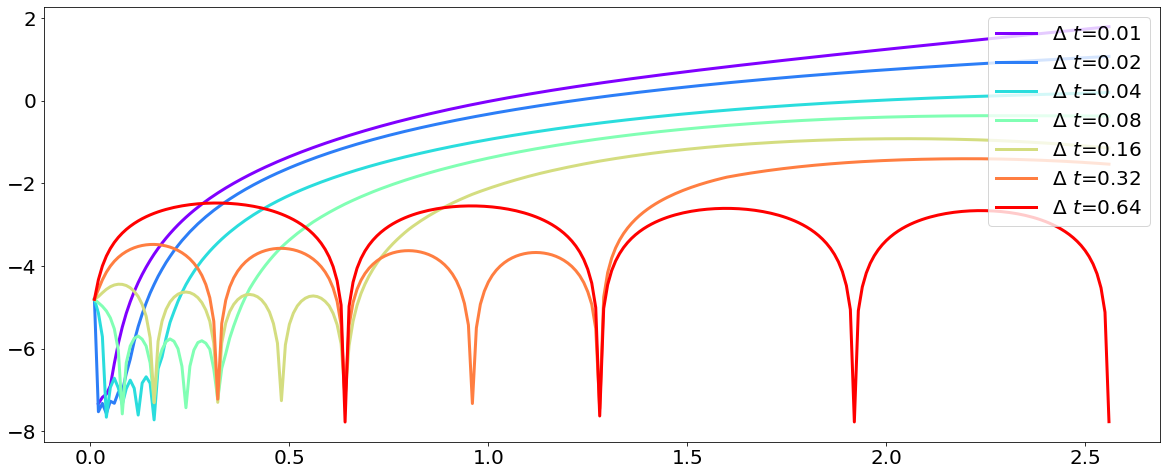

In [7]:
# uniscale time-stepping with NN
preds_mse = list()
times = list()

for model in tqdm(models):
    start = time.time()
    y_preds = model.uni_scale_forecast(
        torch.tensor(test_data[:, 0, :]).float(), n_steps=n_steps
        )
    end = time.time()
    times.append(end - start)
    preds_mse.append(criterion(torch.tensor(test_data[:, 1:, :]).float(), y_preds).mean(-1))
    
# visualize forecasting error at each time step    
fig = plt.figure(figsize=(20, 8))
colors=iter(plt.cm.rainbow(np.linspace(0, 1, len(ks))))
for k in range(len(preds_mse)):
    err = preds_mse[k]
    mean = err.mean(0).detach().numpy()
    rgb = next(colors)
    plt.plot(t, np.log10(mean), linestyle='-', color=rgb, linewidth=3.0, label='$\Delta\ t$={}'.format(step_sizes[k]*dt))
plt.legend(fontsize=20, loc='upper right')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

In [8]:
# cross validation (model selections) 
start_idx = 0
end_idx = len(models)
best_mse = 1e+5

# choose the largest time step
for i in tqdm(range(len(models))):
    y_preds = net.vectorized_multi_scale_forecast(
        torch.tensor(val_data[:, 0, :]).float(), 
        n_steps=n_steps, models=models[:len(models)-i]
        )
    mse = criterion(torch.tensor(val_data[:, 1:, :]).float(), y_preds).mean().item()
    if mse <= best_mse:
        end_idx = len(models)-i
        best_mse = mse

# choose the smallest time step
for i in tqdm(range(end_idx)):
    y_preds = net.vectorized_multi_scale_forecast(torch.tensor(val_data[:, 0, :]).float(), n_steps=n_steps, models=models[i:end_idx])
    mse = criterion(torch.tensor(val_data[:, 1:, :]).float(), y_preds).mean().item()
    if mse <= best_mse:
        start_idx = i
        best_mse = mse
        
print('use models {} - {}.'.format(start_idx, end_idx))
models = models[start_idx:end_idx]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

use models 6 - 7.


(array([-10.,  -8.,  -6.,  -4.,  -2.,   0.,   2.,   4.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

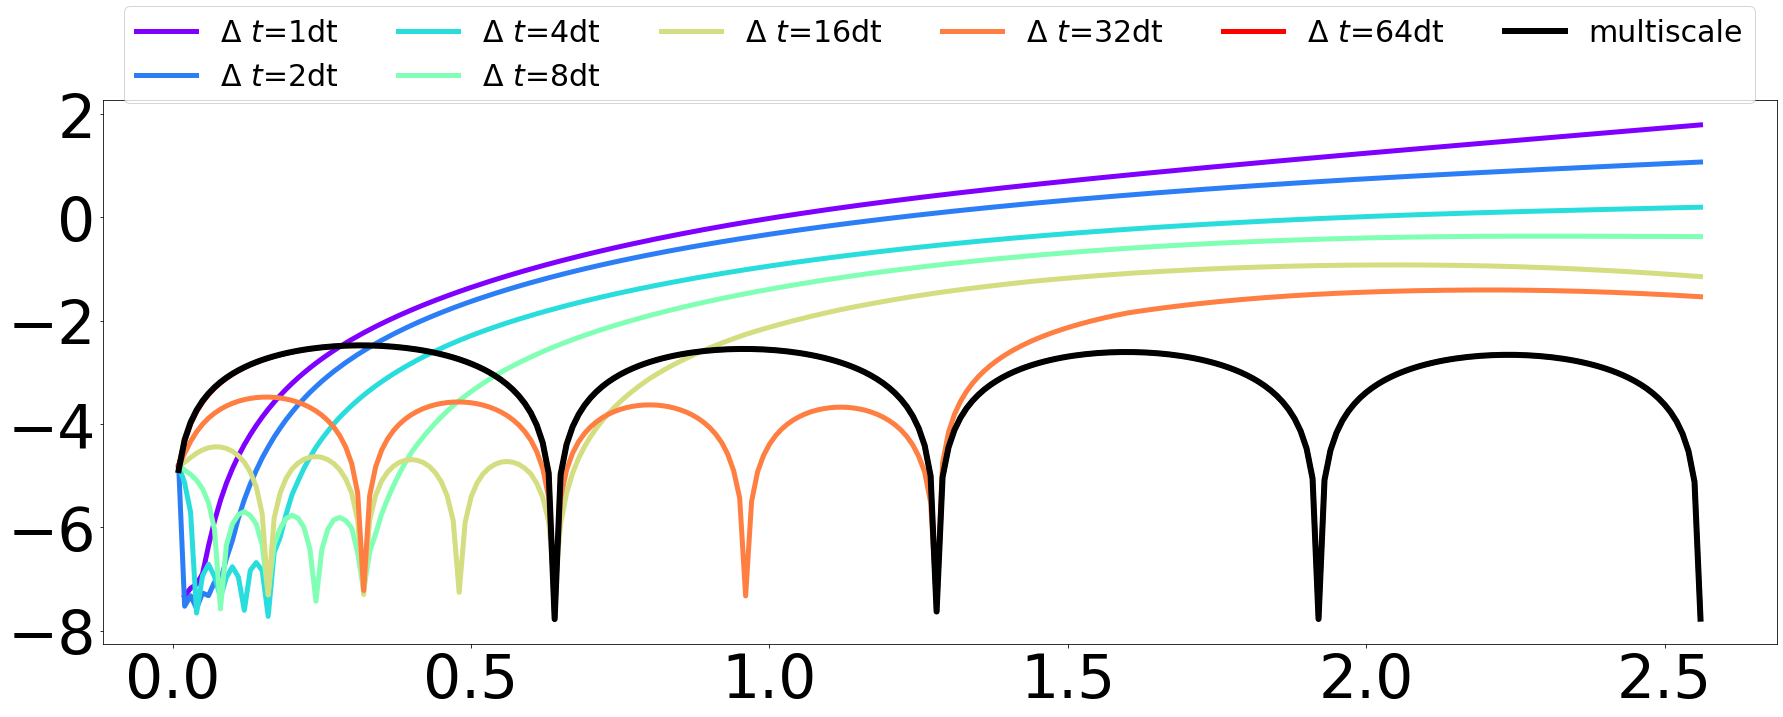

In [9]:
# multiscale time-stepping with NN
start = time.time()
y_preds = net.vectorized_multi_scale_forecast(torch.tensor(test_data[:, 0, :]).float(), n_steps=n_steps, models=models)
end = time.time()
multiscale_time = end - start
multiscale_preds_mse = criterion(torch.tensor(test_data[:, 1:, :]).float(), y_preds).mean(-1)

# visualize forecasting error at each time step    
fig = plt.figure(figsize=(30, 10))
colors=iter(plt.cm.rainbow(np.linspace(0, 1, len(ks))))
multiscale_err = multiscale_preds_mse.mean(0).detach().numpy()
for k in range(len(preds_mse)):
    err = preds_mse[k]
    mean = err.mean(0).detach().numpy()
    rgb = next(colors)
    plt.plot(t, np.log10(mean), linestyle='-', color=rgb, linewidth=5, label='$\Delta\ t$={}dt'.format(step_sizes[k]))
plt.plot(t, np.log10(multiscale_err), linestyle='-', color='k', linewidth=6, label='multiscale')
plt.legend(fontsize=30, loc='upper center', ncol=6, bbox_to_anchor=(0.5, 1.2))
plt.xticks(fontsize=60)
plt.yticks(fontsize=60)

No handles with labels found to put in legend.


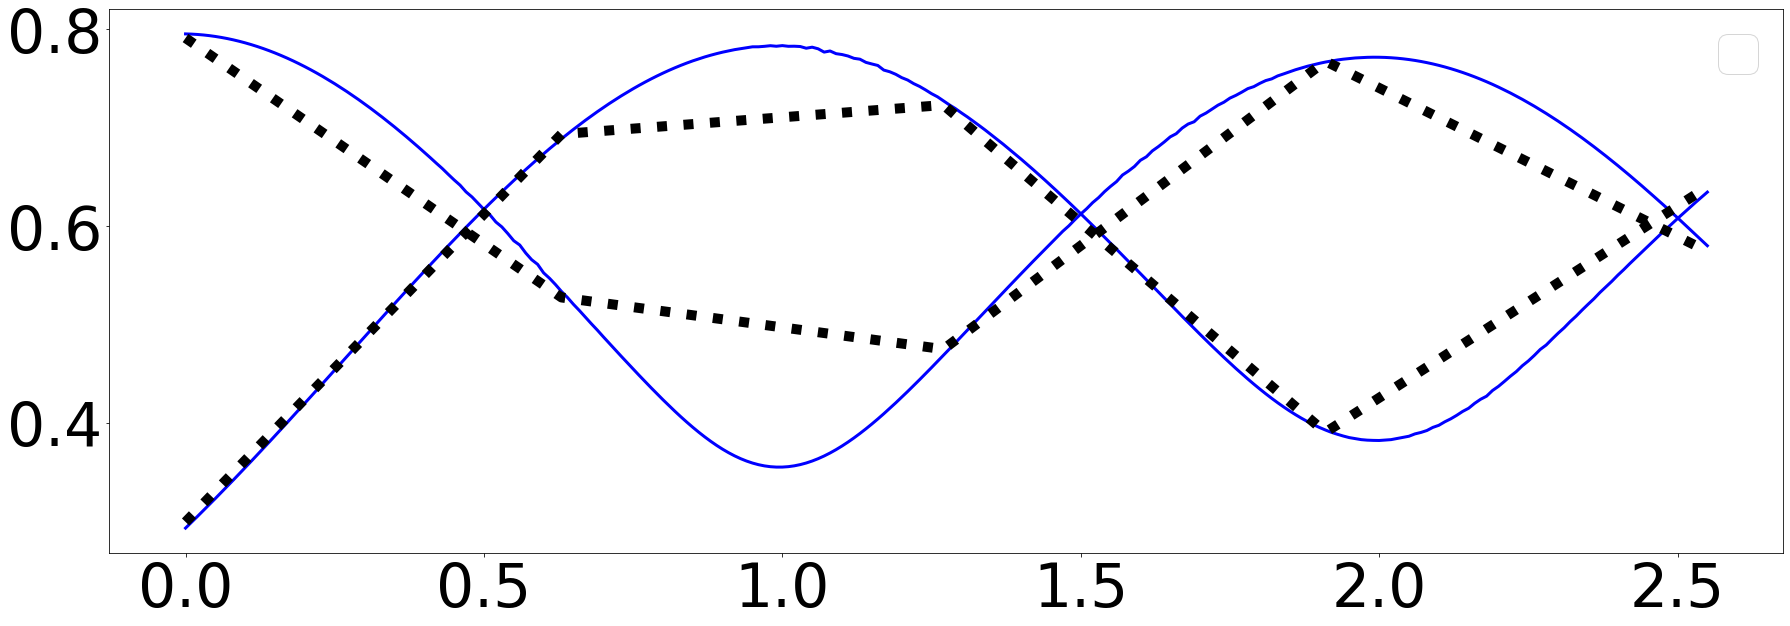

In [10]:
# integration of a sampled test trial 
# (you need to change the code here accordingly as state variables are different for different systems)
idx = 24
t = np.linspace(0, (n_steps-1)*dt, n_steps)
fig = plt.figure(figsize=(30, 10))
gs = gridspec.GridSpec(nrows=1, ncols=1, hspace=0.5)
ax0 = fig.add_subplot(gs[0, :])
ax0.plot(t, test_data[idx, 0:n_steps, ::64], 'b-', linewidth=3)
ax0.plot(t, y_preds[idx, 0:n_steps, ::64].detach().numpy(), 'k:', linewidth=10)
ax0.legend(fontsize=50, loc='upper right')
ax0.tick_params(axis='both', which='major', labelsize=60)

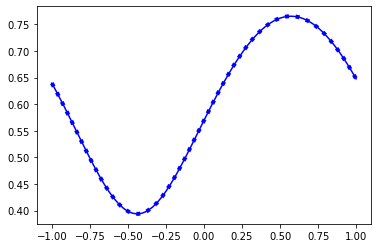

In [11]:
fig = plt.figure()
plt.plot(np.linspace(-1,1,nx), y_preds[idx,-1,:], 'b:', linewidth=4)
plt.plot(np.linspace(-1,1,nx), test_data[idx,-1,:], 'b-')

In [12]:
# computation time
for i in range(len(times)):
    print('single scaled model (Dt={}): computing time {}s'.format(step_sizes[i]*dt, times[i]))
print('ensembled multiscale model: computing time {}s'.format(multiscale_time))

single scaled model (Dt=0.01): computing time 0.9081151485443115s
single scaled model (Dt=0.02): computing time 0.32966017723083496s
single scaled model (Dt=0.04): computing time 0.1576216220855713s
single scaled model (Dt=0.08): computing time 0.10304069519042969s
single scaled model (Dt=0.16): computing time 0.07897281646728516s
single scaled model (Dt=0.32): computing time 0.05191779136657715s
single scaled model (Dt=0.64): computing time 0.059305667877197266s
ensembled multiscale model: computing time 0.04512214660644531s
